# Predicting Breast Cancer
In this exercise, we'll explore a valuable application of Machine Learning: predicting whether or not tumors are **benign** or **malignant**. We'll use the (real) [Wisconsin Breast Cancer dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names), that is included in the `sklearn` library. Through this exercise, you'll learn the steps associated with implementing a Machine Learning algorithm.

## Set up

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import the dataset from sklearn
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

# Convert to Pandas dataframe for some exploration
data_pd = pd.DataFrame(columns=data.feature_names, data=data.data)
data_pd.columns = [c.replace(' ', '_') for c in data_pd.columns] # replace spaces
data_pd['outcome'] = data.target

In [2]:
# Flip benign and malignant codes (currently 0 for malignant, 1 for benign)
data_pd.outcome = np.where(data_pd.outcome == 1, 0, 1)

## Brief data exploration

In [3]:
# What is the correlation between each column and the outcome of interest
corrs = data_pd.corr().outcome
corrs.sort_values()

smoothness_error          -0.067016
mean_fractal_dimension    -0.012838
texture_error             -0.008303
symmetry_error            -0.006522
fractal_dimension_error    0.077972
concavity_error            0.253730
compactness_error          0.292999
worst_fractal_dimension    0.323872
mean_symmetry              0.330499
mean_smoothness            0.358560
concave_points_error       0.408042
mean_texture               0.415185
worst_symmetry             0.416294
worst_smoothness           0.421465
worst_texture              0.456903
area_error                 0.548236
perimeter_error            0.556141
radius_error               0.567134
worst_compactness          0.590998
mean_compactness           0.596534
worst_concavity            0.659610
mean_concavity             0.696360
mean_area                  0.708984
mean_radius                0.730029
worst_area                 0.733825
mean_perimeter             0.742636
worst_radius               0.776454
mean_concave_points        0

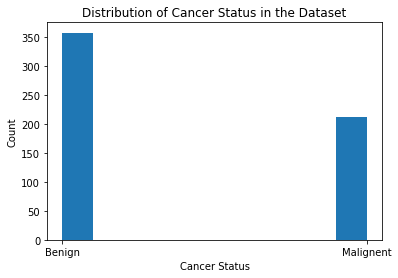

In [4]:
# Distribution of outcomes
plt.hist(data_pd.outcome)
plt.xticks((0, 1), ("Benign", "Malignent"))
plt.xlabel("Cancer Status")
plt.ylabel("Count")
plt.title("Distribution of Cancer Status in the Dataset")
plt.show()

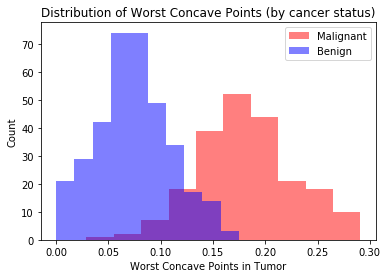

In [5]:
# What is the distribution of "worst_concave_points" (for benign, malignant)?
malignant = data_pd[data_pd.outcome == 1]
benign = data_pd[data_pd.outcome != 1]

# Draw histograms of the distribution
plt.hist(malignant["worst_concave_points"], alpha=0.5, label='Malignant', color="red")
plt.hist(benign["worst_concave_points"], alpha=0.5, label='Benign', color="blue")
plt.legend(loc='upper right')
plt.xlabel("Worst Concave Points in Tumor")
plt.ylabel("Count")
plt.title("Distribution of Worst Concave Points (by cancer status)")
plt.show()

## Our First Machine Learning Model: A Decision Tree
Without doing any pre-processing (or considering the idea of training/testing data), let's try implementing our first machine learning model, a **Decision Tree**. Like any model, it will involve a few steps (to be elaborated upon as we go):

- **Import** your model from `sklearn`
- **Create** your model with the desired parameters
- **Fit** your model to the data
- **Assess** performance of the model

In [6]:
# Import your model, a decision tree classifier  
# (typically imported at the beginning of your script)
from sklearn.tree import DecisionTreeClassifier

In [25]:
# Create a classifier, then fit the model to your data (creating a decision tree)
# To ensure consistent results, we can use the random_state parameter
tree_clf = DecisionTreeClassifier(random_state=185)
tree_fit = tree_clf.fit(data_pd.drop("outcome", axis=1), data_pd.outcome)



In [17]:
# Assess the fit of the model by generating predictions using your data
# Then calculate the accuracy (percentage of the time that the predictions equal the outcome)
sum(tree_fit.predict(data.data) == data_pd.outcome)/data_pd.shape[0]

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(tree_fit.predict(data.data), data.target)
accuracy

0.0

## Training and Testing Data
In actual machine learning applications, the intention is to **predict unknown values**. In the example above, you were able to perfectly predict the values because _your model has seen them_. To simulate a _real world_ application, it's necessary to **hide testing data from your model**, and then use your hidden (**test**) data to assess your performance. This can easily be achieved using the `test_train_split` method from `sklearn`. We'll augment our machine learning process to now include splitting our dataset into testing and training data:



- **Import** your model
- **Create** your model
- <span style="color:red">**Split** data into training and testing data</span>
- **Fit** your model to **training** data
- **Assess** performance of the model on your **test** data

In [23]:
# Split your data into test and training data with a test size of 30% (.3)
from sklearn.model_selection import train_test_split # typically done at the start

train_features, test_features, train_outcome, test_outcome = train_test_split(
    data.data,
    data.target,
    test_size=0.20,
    random_state=11
)
data.data.shape
print("train_features_shape", train_features.shape)
print("test_features_shape", test_features.shape)
print("full datasets features shape", data.data.shape)
print("test outcome shape", test_outcome.shape)
print("test outcome shape", train_outcome.shape)

train_features_shape (455, 30)
test_features_shape (114, 30)
full datasets features shape (569, 30)
test outcome shape (114,)
test outcome shape (455,)


In [27]:
# Fit the classifier -- from above -- using our (training) data 
fit = tree_clf.fit(train_features, train_outcome)

In [30]:
# Assess the model using our (test) data. 
# You can import and use the `accuracy_score` fucntion rather than manually computing it
from sklearn.metrics import accuracy_score
accuracy_score(fit.predict(test_features), test_outcome)

0.9649122807017544

In [31]:
# Not required: use graphviz to visualize your tree
#import graphviz
from sklearn import tree 
tree.export_graphviz(tree_clf, 
                     feature_names=data.feature_names, 
                     class_names=['Benign', 'Malig.'], 
                     out_file="mytree.dot"
)
# To convert, you'll need to install graphviz: conda install grahpviz
# Then on your terminal: dot -Tpng mytree.dot -o mytree.png

## Our Second Model: K-Nearest Neighbors
K-Nearest Neighbors is a very simple algorithm. To identify the classification of any observation (row), we simply need to look at the class of K similar points. This introduces two new questions:

1. How do we decide on the number of neighbors to use for classifying any given point (K)?
2. How do we calculate distance when our features (columns) are in different units?

We'll address each of these challenges in the following sections. However, we'll start by simply implementing the algorithm (which will follow the same process as other algorithms). 

In [33]:
# Import and create a KNN classifier that uses the 4 nearest points
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=4, weights='distance')

In [35]:
# Fit the model to our (training) data, and use it to predict on our *test data*
fit = knn_clf.fit(train_features, train_outcome)







In [36]:
# Assess the accuracy of the model
accuracy_score(fit.predict(test_features), test_outcome)

0.9473684210526315

### Picking the number of neighbors (K)
In the above section, we arbitrarily used the number 4 for K. We want to use a data driven process for picking this value. Because we **don't look at the test data** until the end, we need another strategy for assessing model parameters. To do this, we can further split the training data into a **validation set** (think of this as a mini-test set), which we can use to search for the best value of **K**. Our process now involves:


- **Import** your model
- **Create** your model
- **Split** data into training and testing data
- <span style="color:red">**Split** _training_ data into (smaller) training and **validation** data</span>
- **Fit** your model to (smaller) **training** data
- <span style="color:red">**Assess** performance of the model on your **validation** data to tweak parameters</span>
- **Assess** performance of the model on your **test** data


In [37]:
# Let's crete a validation set by sampling 20% (.2) out of the *training* data
# We can use the `train_test_set` function as before
train_features_small, validation_features, train_outcome_small, validation_outcome = train_test_split(
    train_features,
    train_outcome,
    test_size = 0.20
)

print("train_features small shape", train_features_small.shape)
print("validation features_shape", validation_features.shape)
print("full training datasets features shape", train_features.shape)
print("validation outcome shape", validation_outcome.shape)
print("train outcome small shape", train_outcome_small.shape)




train_features small shape (364, 30)
validation features_shape (91, 30)
full training datasets features shape (455, 30)
validation outcome shape (91,)
train outcome small shape (364,)


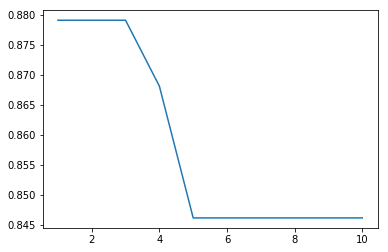

In [41]:
# Let's assess accuracies of K from 1 through 10. To do this, loop through values of K, 
# and in each loop:
# - Create a new classifier using K as the number of neighbors, 
# - Fit the classifier to the (small) training data (without validation data)
# - Generate a set of predictions using the validation data
# - Compute the accuracy of your model on your validation data
accuracies = {}
for k in range(1, 11):
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    knn_clf.fit(train_features_small, train_outcome_small)
    accuracy = accuracy_score(knn_clf.predict(validation_features), validation_outcome)
    accuracies[k] = accuracy
    
accuracies



plt.plot(accuracies.keys(), accuracies.values())

max(accuracies.values())

In [42]:
# Now that you know the best value of K based on your *validation* data, 
# Run the KNN with the optimal value of K on the *test* data to assess your performance

knn_clf = KNeighborsClassifier(n_neighbors=6)
knn_clf.fit(train_features, train_outcome)
accuracy_score(knn_clf.predict(test_features), test_outcome)




0.9473684210526315

## Cross Validation
In the above example, we created a **single** validation dataset from our training data. However, because this sampling is **random**, we may have gotten a certain subset of the training set simply **by chance**. The most popular strategy for solving this issue (and therefore better leveraging the information in our _training data_) is called **cross validation**. 

There are a number of strategies for cross-validation, but the philosophy is the same: split the training data into a (smaller) training and a validation set **multiple times**. 

For example, a popular approach is the **K Fold** cross validation which splits the data into K folds (_not_ to be confused with the __K__ from KNN). Then, each _fold_ of the data is used as the validation set one time. This allows each observation to appear in the validation set one time. You then assess model performance for each fold, and pick your best model based on the **average** performance across the folds (see diagram below from [this book](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Model-validation-via-cross-validation)). 

![K fold validation diagram](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-5-fold-CV.png)

Luckily, the `sklearn` toolkit has a variety of built-in methods for performing this process. This is really only a minor change to our process:

- **Import** your model
- **Create** your model
- **Split** data into training and testing data
- <span style="text-decoration:line-through">**Split** _training_ data into (smaller) training and **validation** data</span> (accomplished in new step below)
- <span style="color:red">**Fit** and **assess** your model using `cross_val_score` to fit the model on different _folds_ of validation data</span>
- <span style="text-decoration:line-through">**Assess** performance of the model on your **validation** data to tweak parameters</span> (accomplished in new step above)
- **Assess** performance of the model on your **test** data

In [43]:
# Use cross validation (`cross_val_score`) to test a classifier 
# across 10 different splits of the data
# Use a K value of 3 for your KNN.
# Notice the huge variation in performance across folds!
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=3)
cross_val_score(knn, train_features, train_outcome, cv=5)
#np.mean(cross_val_score(knn, train_features, train_outcome, cv=5))

array([0.86956522, 0.95604396, 0.93406593, 0.92307692, 0.92222222])

## Grid Search
Unfortunately, the above code only runs a **single model** across __K__ different _folds_ of the data. What we really want to do is iterate over our parameter space (the number of different **neighbors**) for each of the folds. While this would be simple enough to write as a loop, we can easily use the **grid search** functionality built into the `sklearn` toolkit. The benefit is that grid search will seach over a _grid_ of **all parameters** of interest regarding your model (while we only have one current parameter to optimize, we could have many). This will allow you to quickly identify the optimal set of parameters for your model. 


- **Import** your model
- **Create** your model
- **Split** data into training and testing data
- <span style="text-decoration:line-through">**Fit** and **assess** your model using `cross_val_score` to fit the model on different _folds_ of validation data</span>
- <span style="color:red">**Fit** and **assess** models using `grid_search` to fit multiple models using **different parameters** on different _folds_ of validation data</span>
- <span style="text-decoration:line-through">**Assess** performance of the model on your **validation** data to tweak parameters</span> (accomplished in new step above)
- **Assess** performance of the (best) model on your **test** data

In [44]:
# Import the `GridSearchCV` model, and specify a grid of parameters
# This will try all possible combination of parameters in a brute force way
# And, it will run cross validation on each combination of parameters
from sklearn.model_selection import GridSearchCV



In [48]:
# Create a grid search estimator for your KNN classifier
# When fit, this will search the parameter grid using cross validation

param_grid = {'n_neighbors':range(1,20),'weights':["uniform", "distance"]}
param_grid

{'n_neighbors': range(1, 20), 'weights': ['uniform', 'distance']}

In [51]:
# Fit the grid search to your training data
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10,  return_train_score=True)
grid_search.fit(train_features, train_outcome)







GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(1, 20), 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [54]:
# Predict and assess performance on your **test** data
grid_search.cv_results_['params'][grid_search.best_index_]
#['params'][grid_search.best_index_]
#grid_search.score(test_features, test_outcome)
grid_search.score(test_features, test_outcome)

0.9473684210526315

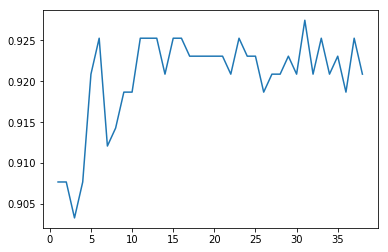

In [59]:
# Visualze performance across neighbors N values
test_scores = grid_search.cv_results_['mean_test_score']
plt.plot(np.arange(1, 39), test_scores)

## Normalizing Data
Because KNN uses a distance based metric to compute similarity, it's important to **normalize** each column to the same scale before running the algorithm. Note, some rule based estimators (like decision trees) aren't sensitive to feature scale (and don't need to be normalized). For example, we can use a `MinMaxScaler` that subracts the minimum, and divides by the difference between the minimum and the maximum of each column.

In order to not **leak information** from out test data into our training data, it's important to normalize our data **after** splitting. We'll worry about integrating this into our process after experimenting with it in the section below.

(array([2., 3., 0., 4., 5., 6., 0., 5., 1., 4.]),
 array([0.06509223, 0.09958135, 0.13407046, 0.16855957, 0.20304868,
        0.2375378 , 0.27202691, 0.30651602, 0.34100513, 0.37549425,
        0.40998336]),
 <a list of 10 Patch objects>)

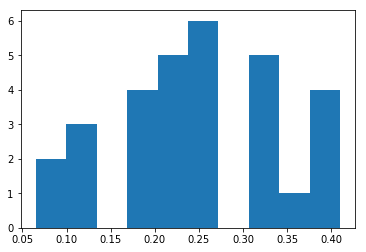

In [64]:
# Manually scale (pre-process) our *training features* (not the outcome!) data
train_features_scaled = (train_features - train_features.min(axis=0)) / (train_features.max(axis=0)-train_features.min(axis=0))
plt.hist(np.mean(train_features_scaled, axis=0))





In [65]:
# Alternatively, we could use a built in Scaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.fit_transform(test_features)

In [66]:
# Fit a knn classifier with the scaled training data
knn = KNeighborsClassifier(n_neighbors=14)
knn.fit(train_features_scaled, train_outcome)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=14, p=2,
           weights='uniform')

In [69]:
# Generate predictions using *scaled test data*
accuracy_score(knn.predict(test_features_scaled), test_outcome)

0.9649122807017544

## Making Pipelines
Our final challenge is determining how to integrate the data scaling into our cross validation process. For **each set** of possible model parameters, we need to:

- **Split** our (training) data into training and validation sets
- **Normalize**/scale each training set
- **Assess** the model on all validation sets


While we could write the iterators to do this ourselves, this is a problem that is already solved using **Pipelines**. The `GridSearchCV` class is structured to take as an argument a _pipeline_ object, which includes each transformation or calculation you want to perform on your data. For example

```python
# Define scaler, classifier, and pipeline to use
scaler = MinMaxScaler()
knn_clf = KNeighborsClassifier()
pipe = make_pipeline(scaler, knn_clf)

# Define grid for pipeline (indicates which arguments are for which classes)
param_grid = {'kneighborsclassifier__n_neighbors': [1, 3, 5, 10]}

# Search through and perform cross validation
grid = GridSearchCV(pipe, param_grid)
```

Our final process will be:

- **Import** your model
- **Create** your model
- **Split** data into training and testing data
- **Create** your normalization (scaling) function
- **Define** a **pipeline** that will implement your pre-processing and your model
- **Fit** and **assess** models using `grid_search` to fit multiple models using **different parameters** on different _folds_ of validation data</span>
- **Assess** performance of the (best) model on your **test** data

In [72]:
# Import pipeline, and define your pipeline that will
# - Transform you data using a MinMaxScaler
# - Fit a KNN classifier
from sklearn.pipeline import make_pipeline

scaler = MinMaxScaler()
knn = KNeighborsClassifier()
param_grid = {'kneighborsclassifier__n_neighbors':range(1, 40),
             'kneighborsclassifier__weight':["uniform", "distance"]
             }

pipeline = make_pipeline(scaler, knn)



In [77]:
# Pass your pipeline to a grid search, specifying a set of neighbors to assess


grid_search = GridSearchCV(pipeline, param_grid=param_grid)






